In [1]:
import numpy as np

x = np.linspace(0, 2 * np.pi, 1000)
y = np.cos(x) ** 2 * np.sqrt(x) * np.log(x + 1) + 0.5 * np.random.randn(x.shape[0]) * np.cos(5 * x)

fft = np.fft.fft(y, norm="ortho")

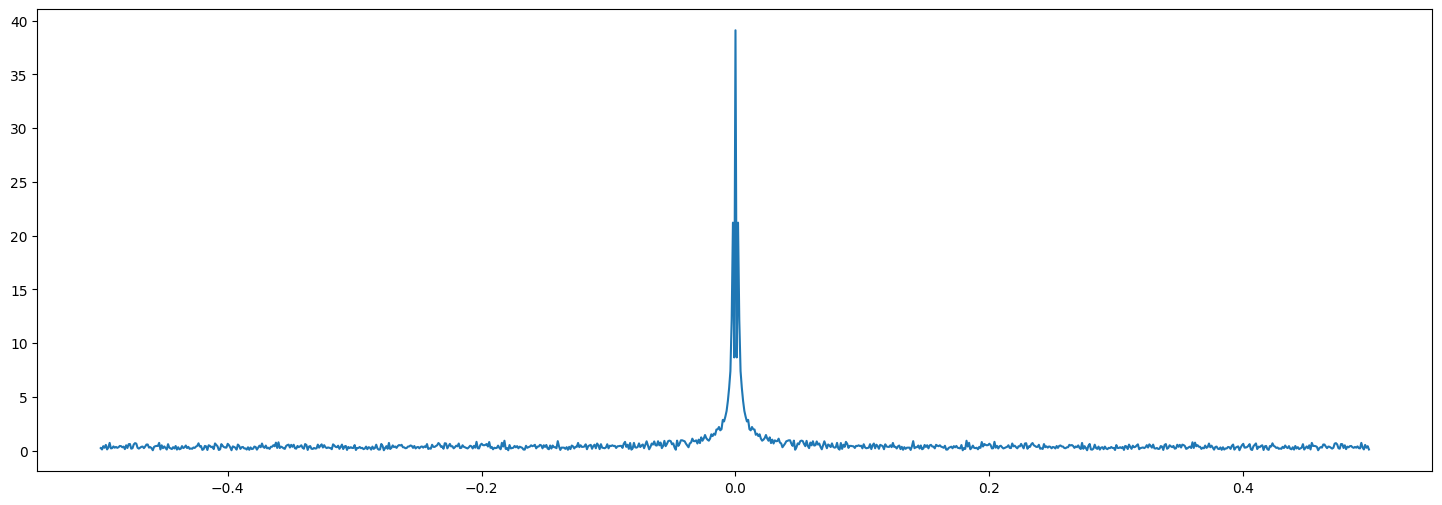

In [ ]:
from matplotlib import pyplot as plt

freqs = np.fft.fftfreq(fft.shape[0])
idx = np.argsort(freqs)

plt.figure(figsize=(18, 6))

plt.plot(freqs[idx], np.abs(fft)[idx])
plt.show()

In [3]:
fft_smoothed = np.fft.fftshift(fft)
fft_phased = fft_smoothed.copy()

N = 475

fft_smoothed[(-1) * N:] = 0
fft_smoothed[:N] = 0

fft_phased[(-1) * N:] = fft_phased[(-1) * N:] * np.exp(np.pi * 1j * np.random.uniform(-1, 1, N) * 0.666)
fft_phased[:N] = fft_phased[:N] * np.exp(np.pi * 1j * np.random.uniform(-1, 1, N) * 0.666)

fft_smoothed = np.fft.ifftshift(fft_smoothed)
fft_phased = np.fft.ifftshift(fft_phased)

In [4]:
z = np.fft.ifft(fft, norm="ortho")
z_smoothed = np.fft.ifft(fft_smoothed, norm="ortho")
z_shifted = np.fft.ifft(fft_phased, norm="ortho")

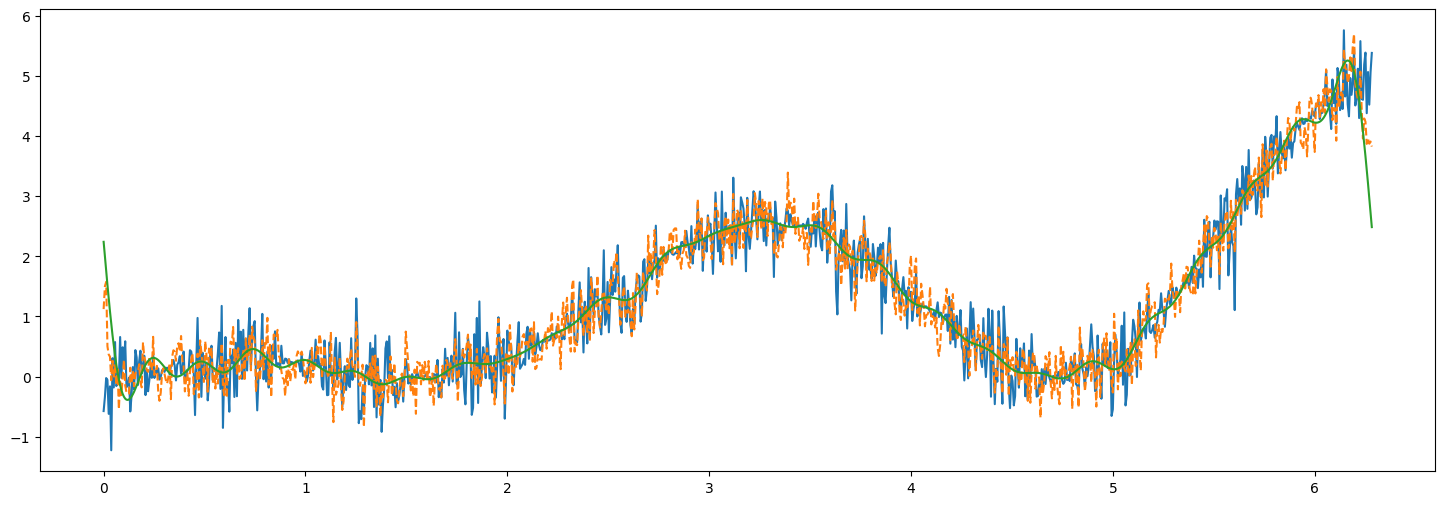

In [ ]:
plt.figure(figsize=(18, 6))

plt.plot(x, y)
plt.plot(x, np.real(z_shifted), '--')
plt.plot(x, np.real(z_smoothed))
plt.show()

In [6]:
print("Smoothed Spat. MSE:", np.mean(np.square(np.abs(z - np.abs(z_smoothed)))))
print("Smoothed Spec. MSE:", np.mean(np.square(np.abs(fft - fft_smoothed))))
print("- - - - - - - - - - - - - - - - - - - -")
print("Noisy Spec. MSE:", np.mean(np.square(np.abs(fft - fft_phased))))

Smoothed Spat. MSE: 0.1727134137118316
Smoothed Spec. MSE: 0.17356398996454386
- - - - - - - - - - - - - - - - - - - -
Noisy Spec. MSE: 0.19802326627326072


In [7]:
amplitude = 0.75

def new_norm(z1, z2):

    loss = (
        + np.real(z2) ** 2 + np.imag(z2) ** 2
        + np.real(z1) ** 2 + np.imag(z1) ** 2
        - 2 * (
            + (1 - amplitude)
            * (np.real(z2) * np.real(z1) + np.imag(z2) * np.imag(z1))
            + amplitude
            * np.abs(z2) * np.abs(z1)
        )
    )

    return loss

In [8]:
print("Smoothed Spec. NEW:", np.mean(new_norm(fft, fft_smoothed)))
print("- - - - - - - - - - - - - - - - - - -")
print("Noisy Spec. NEW:", np.mean(new_norm(fft, fft_phased)))

Smoothed Spec. NEW: 0.17356398996454378
- - - - - - - - - - - - - - - - - - -
Noisy Spec. NEW: 0.04950581656831517


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

In [10]:
class SpecLossEnergy(nn.Module):

    def __init__(self):

        super().__init__()
    
    def forward(self, forc, real):

        forc = torch.fft.rfft(forc, norm="ortho")
        real = torch.fft.rfft(real, norm="ortho")

        loss = torch.square(torch.abs(forc) - torch.abs(real))

        loss[0] = 0.5 * loss[0]

        return torch.sqrt(torch.mean(loss))


class SpecLossCustom(nn.Module):

    def __init__(self):

        super().__init__()
        n = np.fft.rfft(x).shape[0]
        self.amplitude = torch.arange(n)
        self.amplitude = torch.log(1 + self.amplitude)
        self.amplitude = self.amplitude / self.amplitude.max()
    
    def forward(self, forc, real):

        forc = torch.fft.rfft(forc, norm="ortho")
        real = torch.fft.rfft(real, norm="ortho")

        loss = (
            + torch.real(forc) ** 2 + torch.imag(forc) ** 2
            + torch.real(real) ** 2 + torch.imag(real) ** 2
            - 2 * (
                + (1 - self.amplitude)
                * (torch.real(forc) * torch.real(real) + torch.imag(forc) * torch.imag(real))
                + self.amplitude
                * torch.abs(forc) * torch.abs(real)
            )
        )

        loss[0] = 0.5 * loss[0]

        return torch.mean(loss)


class SpecLossAMSE(nn.Module):

    def __init__(self):

        super().__init__()
        self.eps = torch.finfo(torch.float32).tiny
    
    def forward(self, forc, real):

        forc = torch.fft.rfft(forc, norm="ortho")
        real = torch.fft.rfft(real, norm="ortho")

        eta_fc = torch.abs(forc)
        eta_rl = torch.abs(real)

        crossam = eta_fc * eta_rl
        coheren = torch.real(forc) * torch.real(real) + torch.imag(forc) * torch.imag(real)
    
        coheren = torch.where(
            (crossam > self.eps),
            (coheren + self.eps) / (crossam + self.eps),
            0,
        )

        loss = (
            + (eta_fc - eta_rl) ** 2
            + (2.0 * torch.max(eta_fc, eta_rl) ** 2)
            * (1.0 - coheren)
        )

        loss[0] = 0.5 * loss[0]

        return torch.mean(loss)

In [11]:
x = torch.linspace(0, 2 * np.pi, 360)
y = torch.sin(x) ** 2 * torch.sqrt(x) * torch.log(x + 1)

y = y - y.mean()
y = y + 0.50 * torch.randn(x.shape)

STD = 0.10

def add_phase_noise(z):

    fft = torch.fft.rfft(z)
    idx = len(fft) // 5
    phs = 2 * torch.rand(len(fft) - idx) - 1
    fft[idx:] = fft[idx:] * torch.exp(0.5 * np.pi * 1j * phs)

    return torch.fft.irfft(fft)

In [12]:
def normal(mu):
    return torch.exp(- 0.5 * (x - mu) ** 2 / STD ** 2)

def noisy_signal_1():
    z = add_phase_noise(y)
    return z

def noisy_signal_2():
    z = y + 0.50 * torch.randn(x.shape)
    return z

def noisy_signal_3():
    mu = np.random.uniform(x[len(x) // 3], x[len(x) * 2 // 3])
    return normal(mu)

def noisy_signal_4():
    mu = np.random.uniform(x[len(x) // 2 - 20], x[len(x) // 2 + 20])
    return normal(mu)

def noisy_signal_5():
    mu = np.random.normal(x[len(x) // 2], x[-1] / 40)
    return normal(mu)

def noisy_signal_6():
    mu1 = np.random.uniform(x[len(x) // 5], x[len(x) * 3 // 5])
    mu2 = mu1 + x[len(x) // 5]
    return normal(mu1) - normal(mu2)

def noisy_signal_7():
    return noisy_signal_4() - noisy_signal_4()

In [13]:
class SpaceModel(nn.Module):

    def __init__(self, num_indices):

        super(SpaceModel, self).__init__()
        x = torch.randn(num_indices)
        self.x = nn.Parameter(x)

    def forward(self):
        return self.x


class FreqModel(nn.Module):

    def __init__(self, num_indices):

        super(FreqModel, self).__init__()
        
        x = torch.randn(num_indices)
        y = torch.randn(num_indices)
        self.z = nn.Parameter(torch.complex(x, y))

    def forward(self):
        z = torch.fft.ifft(self.z, norm="forward")
        return torch.real(z)

In [14]:
model = SpaceModel(len(x))

spec_loss_energy = SpecLossEnergy()
spec_loss_custom = SpecLossCustom()
spec_loss_amse = SpecLossAMSE()

mse = nn.MSELoss()
mae = nn.L1Loss()

signal = noisy_signal_6
loss = lambda x, y: spec_loss_energy(x, y) + mae(x, y)

optimizer = optim.AdamW(model.parameters(), lr=5e-4)
max_epoch = 10000
epochsize = 5

In [15]:
model.train()

for e in range(max_epoch + 1):

    # Forward pass
    forc = model()
    step_loss = sum(loss(forc, signal()) for _ in range(epochsize)) / epochsize

    # Backward pass
    optimizer.zero_grad()
    step_loss.backward()
    optimizer.step()

    if e % (max_epoch / 10) == 0:
        print(f"Epoch [{e}/{max_epoch}], Loss: {step_loss.item():.2E}")

Epoch [0/10000], Loss: 1.80E+00
Epoch [1000/10000], Loss: 1.11E+00
Epoch [2000/10000], Loss: 6.60E-01
Epoch [3000/10000], Loss: 3.88E-01
Epoch [4000/10000], Loss: 2.63E-01
Epoch [5000/10000], Loss: 1.68E-01
Epoch [6000/10000], Loss: 1.53E-01
Epoch [7000/10000], Loss: 1.50E-01
Epoch [8000/10000], Loss: 1.44E-01
Epoch [9000/10000], Loss: 1.59E-01
Epoch [10000/10000], Loss: 1.25E-01


In [16]:
model.eval()

y_real = signal()
y_forc = model().detach()

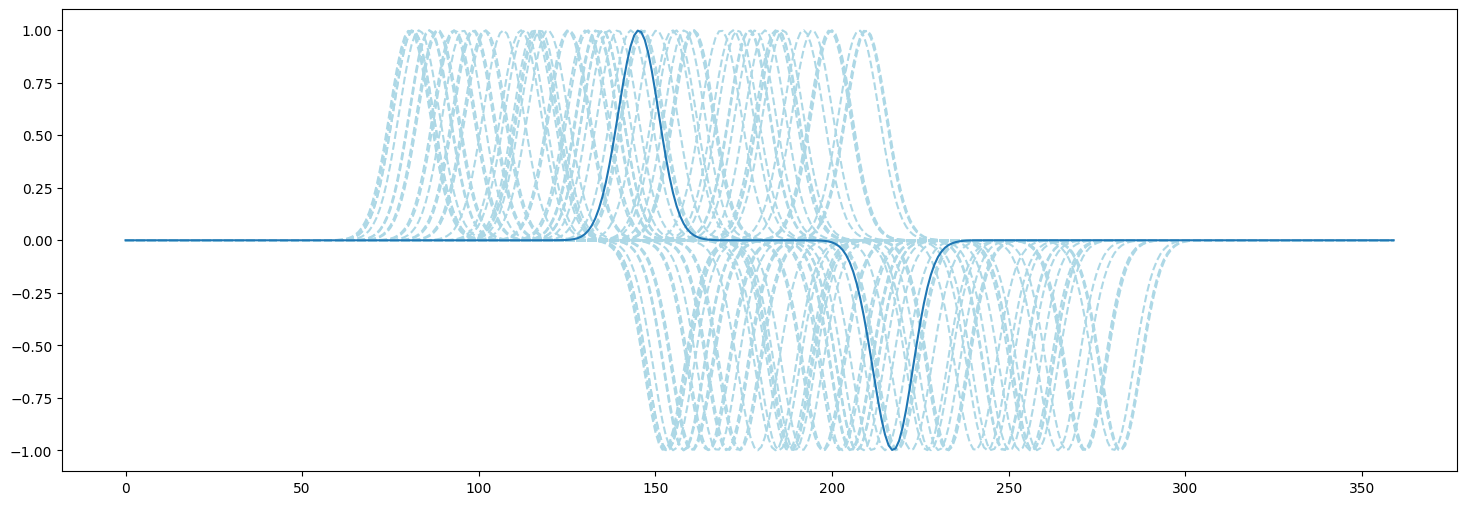

In [ ]:
plt.figure(figsize=(18, 6))

stance = lambda s: plt.plot(s, "--", c="lightblue")

for _ in range(1 << 6): stance(signal().numpy())

plt.plot(y_forc.numpy())
plt.show()

In [18]:
fft_real = torch.fft.fft(y_real)
fft_forc = torch.fft.fft(y_forc)

energy_gain = torch.abs(fft_forc) / torch.abs(fft_real)
phase_angle = torch.angle(fft_forc) - torch.angle(fft_real)
phase_coher = 0.5 * (1 - torch.cos(phase_angle))

print("Energy Gain:", torch.median(energy_gain))
print("Phase Coherence:", torch.median(phase_coher))

Energy Gain: tensor(109.3560)
Phase Coherence: tensor(0.5459)


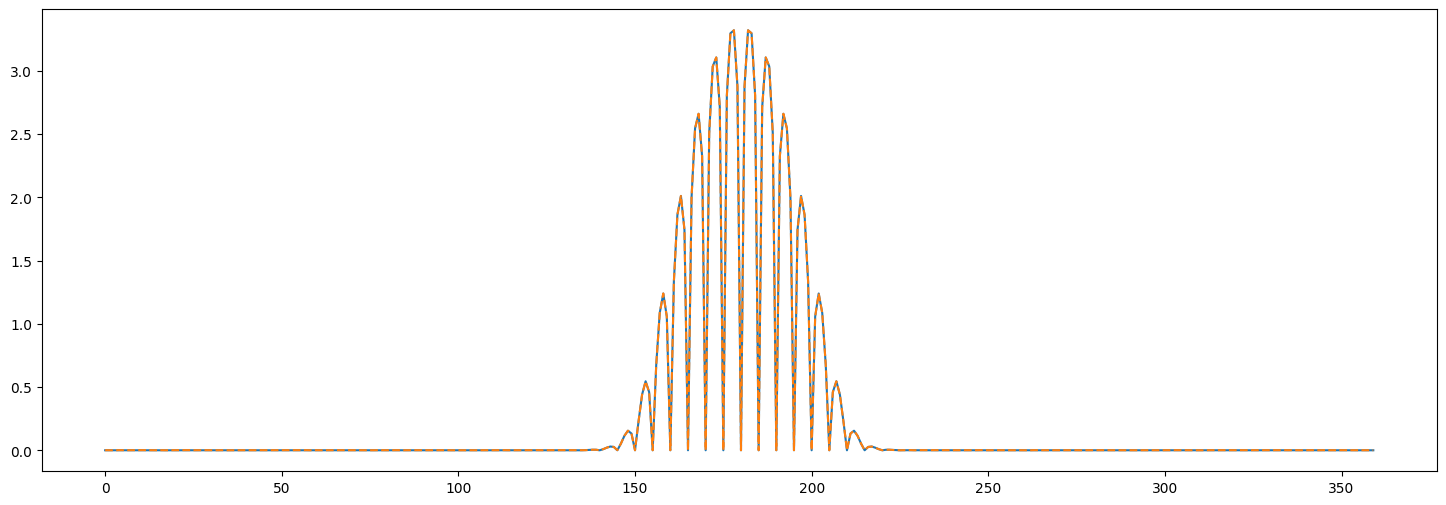

In [ ]:
plt.figure(figsize=(18, 6))

logenergy_real = np.fft.fftshift(torch.log1p(torch.abs(fft_real)))
logenergy_forc = np.fft.fftshift(torch.log1p(torch.abs(fft_forc)))

plt.plot(logenergy_real)
plt.plot(logenergy_forc, '--')
plt.show()

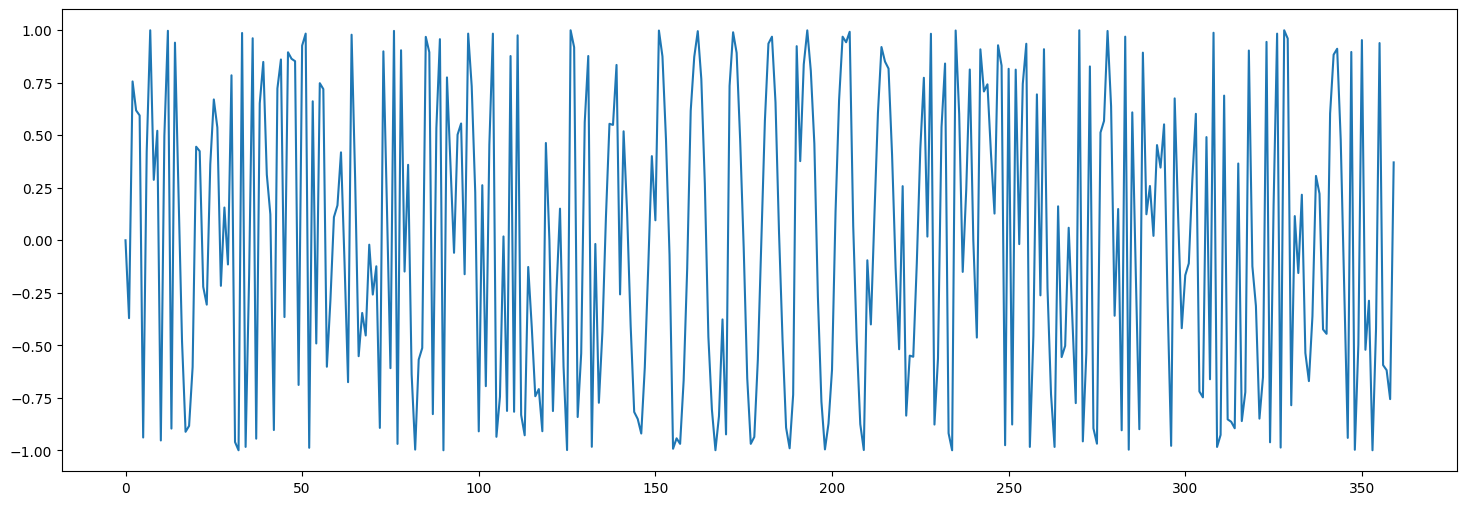

In [ ]:
phase_sin = np.fft.fftshift(torch.sin(phase_angle))

plt.figure(figsize=(18, 6))
plt.plot(phase_sin)
plt.show()

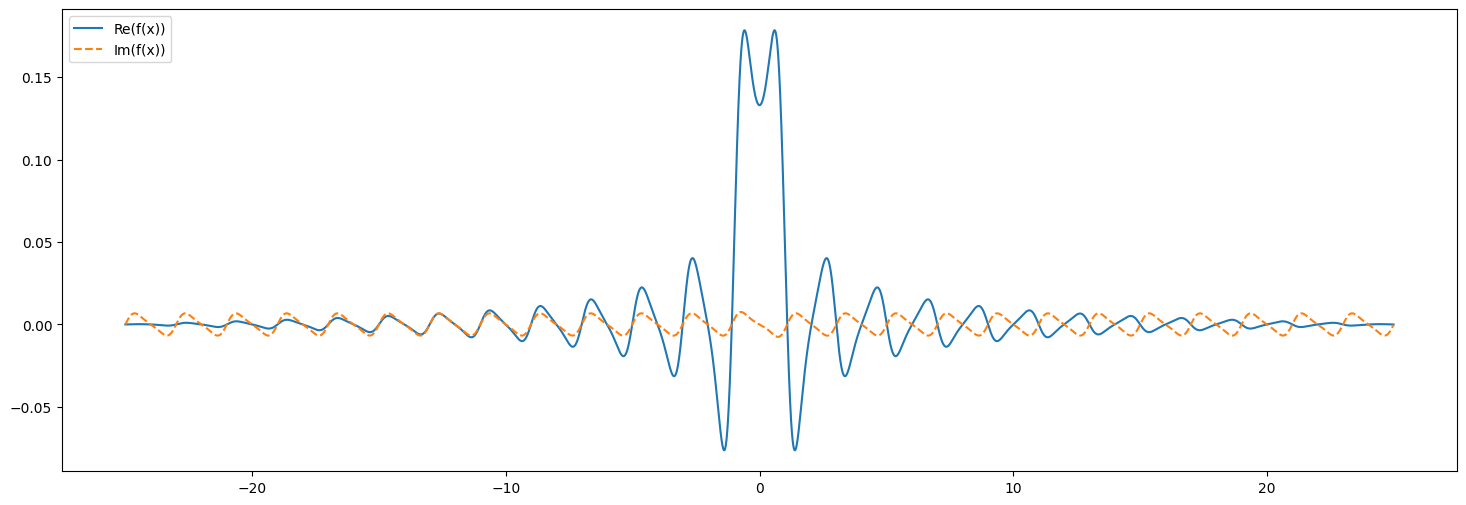

In [ ]:
sigma = 0.3
sagma = 0.5 / sigma ** 2
scale = 2.0 * np.sqrt(1 / (sagma * np.pi))

def mse_minimizer(k):
    target = scale * np.exp(- (np.pi ** 2 * k ** 2) / sagma)
    return target * np.sign(np.sinc(2 * k))

n, w = 10000, 100
spec = mse_minimizer(np.linspace(-w, w, n))

spec = np.fft.ifftshift(spec)
spat = np.fft.ifft(spec, norm="ortho")
spat = np.fft.fftshift(spat)
spat = spat

xpos = np.fft.fftshift(np.fft.fftfreq(n, d=(2 * w) / n))

plt.figure(figsize=(18, 6))
plt.plot(xpos, np.real(spat), label='Re(f(x))')
plt.plot(xpos, np.imag(spat), linestyle='dashed', label='Im(f(x))')

plt.legend(loc='upper left')

plt.show()

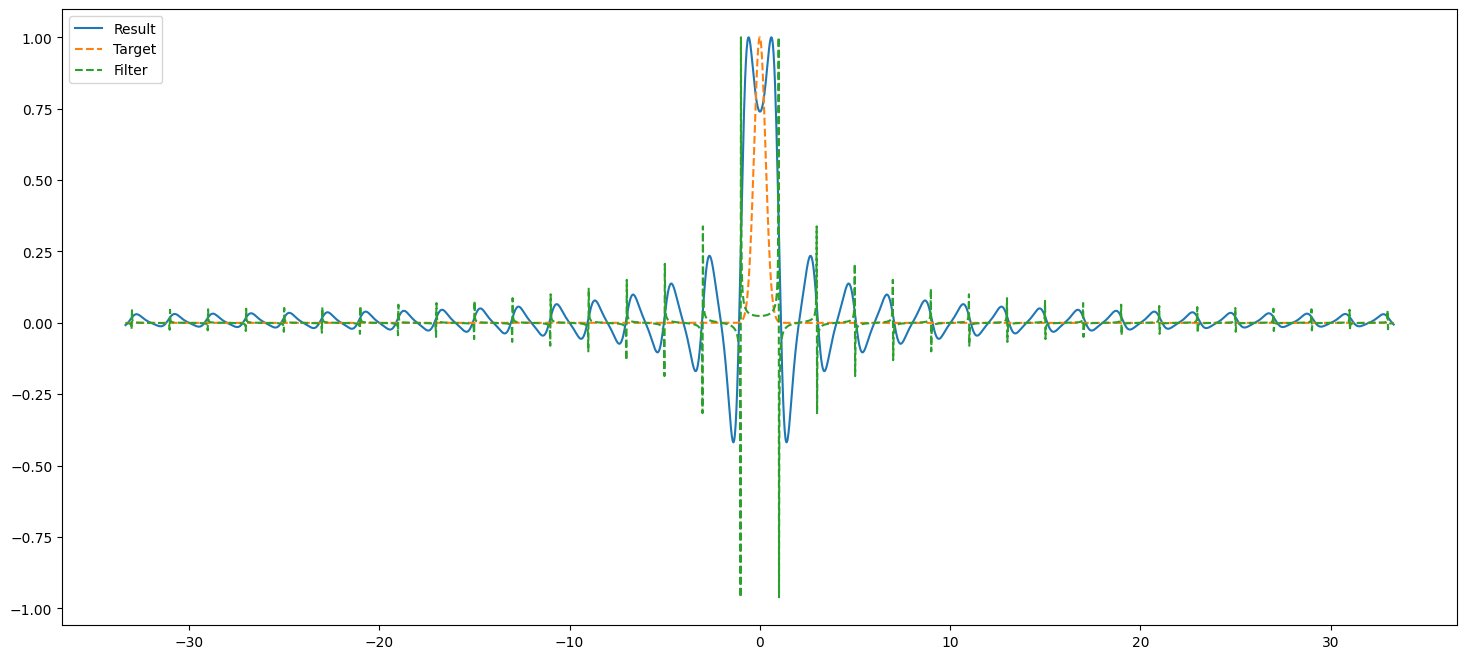

In [22]:
xpos = np.linspace(-w, w, n)

target = scale * np.exp(- sagma * xpos ** 2)
filter = np.tan(np.pi * xpos / 2) * np.pi / (2 * xpos)
result = np.convolve(target, filter, mode="same")

target = target / target.max()
filter = filter / filter.max()
result = result / result.max()

idx = slice(xpos.shape[0] // 3, 2 * xpos.shape[0] // 3)

plt.figure(figsize=(18, 8))
plt.plot(xpos[idx], result[idx], label='Result')
plt.plot(xpos[idx], target[idx], linestyle='dashed', label='Target')
plt.plot(xpos[idx], filter[idx], linestyle='dashed', label='Filter')

plt.legend(loc='upper left')

plt.show()